In [4]:
import multiprocessing
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from sklearn.model_selection import train_test_split
from lightfm.cross_validation import random_train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import numpy as np

num_threads = multiprocessing.cpu_count()
print(num_threads)

8


In [5]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831161 sha256=df7634129561ecaf814797a1d304f698febf1278ffa3587a5e32fef6f76ea464
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [6]:
%%bash
wget --no-check-certificate 'https://drive.usercontent.google.com/download?id=1qe5hOSBxzIuxBb1G_Ih5X-O65QElollE&export=download&confirm=t&uuid=b2002093-cc6e-4bd5-be47-9603f0b33470
' -O KuaiRec.zip
unzip KuaiRec.zip -d data_final_project



Archive:  KuaiRec.zip
   creating: data_final_project/KuaiRec 2.0/
  inflating: data_final_project/KuaiRec 2.0/LICENSE  
  inflating: data_final_project/KuaiRec 2.0/Statistics_KuaiRec.ipynb  
   creating: data_final_project/KuaiRec 2.0/data/
  inflating: data_final_project/KuaiRec 2.0/data/big_matrix.csv  
  inflating: data_final_project/KuaiRec 2.0/data/item_categories.csv  
  inflating: data_final_project/KuaiRec 2.0/data/item_daily_features.csv  
  inflating: data_final_project/KuaiRec 2.0/data/kuairec_caption_category.csv  
  inflating: data_final_project/KuaiRec 2.0/data/small_matrix.csv  
  inflating: data_final_project/KuaiRec 2.0/data/social_network.csv  
  inflating: data_final_project/KuaiRec 2.0/data/user_features.csv  
   creating: data_final_project/KuaiRec 2.0/figs/
  inflating: data_final_project/KuaiRec 2.0/figs/KuaiRec.png  
  inflating: data_final_project/KuaiRec 2.0/figs/colab-badge.svg  
  inflating: data_final_project/KuaiRec 2.0/loaddata.py  


--2025-05-15 14:03:14--  https://drive.usercontent.google.com/download?id=1qe5hOSBxzIuxBb1G_Ih5X-O65QElollE&export=download&confirm=t&uuid=b2002093-cc6e-4bd5-be47-9603f0b33470%0A
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.125.132, 2404:6800:4008:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.125.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 431964858 (412M) [application/octet-stream]
Saving to: ‘KuaiRec.zip’

     0K .......... .......... .......... .......... ..........  0% 22.9M 18s
    50K .......... .......... .......... .......... ..........  0% 48.0M 13s
   100K .......... .......... .......... .......... ..........  0% 88.2M 10s
   150K .......... .......... .......... .......... ..........  0% 84.0M 9s
   200K .......... .......... .......... .......... ..........  0% 76.6M 8s
   250K .......... .......... .......... .......... ..........  0% 28.4M 9s
   300K .......

In [8]:
try:
    small_matrix = pd.read_csv("KuaiRec/data/small_matrix.csv")
    big_matrix = pd.read_csv("KuaiRec/data/big_matrix.csv")
    item_categories = pd.read_csv("KuaiRec/data/item_categories.csv")
    user_features = pd.read_csv("KuaiRec/data/user_features.csv")
    item_daily_features = pd.read_csv("KuaiRec/data/item_daily_features.csv")
    caption_category = pd.read_csv("KuaiRec/data/kuairec_caption_category.csv", engine="python", on_bad_lines="skip")
    social_network = pd.read_csv("KuaiRec/data/social_network.csv")
except pd.errors.ParserError as e:
    print("Error parsing CSV file:", e)

In [9]:
small_matrix_size = small_matrix.shape
big_matrix_size = big_matrix.shape
item_categories_size = item_categories.shape
user_features_size = user_features.shape
item_daily_features_size = item_daily_features.shape
caption_category_size = caption_category.shape
social_network_size = social_network.shape

print("\nDataframe sizes before data cleaning:")
print("Small matrix shape:", small_matrix.shape)
print("Big matrix shape:", big_matrix.shape)
print("Item categories shape:", item_categories.shape)
print("User features shape:", user_features.shape)
print("Item daily features shape:", item_daily_features.shape)
print("Caption category shape:", caption_category.shape)
print("Social network shape:", social_network.shape)

small_matrix.dropna(inplace=True)
small_matrix.drop_duplicates(inplace=True)

big_matrix.dropna(inplace=True)
big_matrix.drop_duplicates(inplace=True)

item_categories.dropna(inplace=True)

user_features.dropna(inplace=True)
user_features.drop_duplicates(inplace=True)

item_daily_features.dropna(inplace=True)
item_daily_features.drop_duplicates(inplace=True)

caption_category.dropna(inplace=True)
caption_category.drop_duplicates(inplace=True)

social_network.dropna(inplace=True)
social_network.drop_duplicates(inplace=True)

small_matrix = small_matrix[small_matrix['timestamp'] >= 0]
big_matrix = big_matrix[big_matrix['timestamp'] >= 0]

small_matrix = small_matrix[small_matrix['user_id'].notnull() & small_matrix['video_id'].notnull()]
big_matrix = big_matrix[big_matrix['user_id'].notnull() & big_matrix['video_id'].notnull()]

print("\nAfter data cleaning:")
print("Small matrix shape:", small_matrix.shape, "size difference:", small_matrix_size[0] - small_matrix.shape[0])
print("Big matrix shape:", big_matrix.shape, "size difference:", big_matrix_size[0] - big_matrix.shape[0])
print("Item categories shape:", item_categories.shape, "size difference:", item_categories_size[0] - item_categories.shape[0])
print("User features shape:", user_features.shape, "size difference:", user_features_size[0] - user_features.shape[0])
print("Item daily features shape:", item_daily_features.shape, "size difference:", item_daily_features_size[0] - item_daily_features.shape[0])
print("Caption category shape:", caption_category.shape, "size difference:", caption_category_size[0] - caption_category.shape[0])
print("Social network shape:", social_network.shape, "size difference:", social_network_size[0] - social_network.shape[0])


Dataframe sizes before data cleaning:
Small matrix shape: (4676570, 8)
Big matrix shape: (12530806, 8)
Item categories shape: (10728, 2)
User features shape: (7176, 31)
Item daily features shape: (343341, 58)
Caption category shape: (10732, 10)
Social network shape: (472, 2)

After data cleaning:
Small matrix shape: (4494578, 8) size difference: 181992
Big matrix shape: (11564987, 8) size difference: 965819
Item categories shape: (10728, 2) size difference: 0
User features shape: (6899, 31) size difference: 277
Item daily features shape: (239968, 58) size difference: 103373
Caption category shape: (9369, 10) size difference: 1363
Social network shape: (472, 2) size difference: 0


In [10]:
item_features = item_daily_features.groupby('video_id').agg({
    'like_cnt': 'sum',
    'like_user_num': 'sum',
    'download_cnt': 'sum',
    'comment_cnt': 'sum',
    'share_cnt': 'sum',
    'valid_play_cnt': 'sum',
    'play_user_num': 'sum',
    'play_duration': 'sum',
    'long_time_play_cnt': 'sum',
    'short_time_play_cnt': 'sum',
    'play_progress': 'mean',
}).reset_index()

In [11]:
big_matrix.to_csv("data/big_matrix_cleaned.csv", index=False)
small_matrix.to_csv("data/small_matrix_cleaned.csv", index=False)
item_features.to_csv("data/item_features_cleaned.csv", index=False)
item_daily_features.to_csv("data/item_daily_features_cleaned.csv", index=False)
item_categories.to_csv("data/item_categories_cleaned.csv", index=False)
user_features.to_csv("data/user_features_cleaned.csv", index=False)
caption_category.to_csv("data/caption_category_cleaned.csv", index=False)
social_network.to_csv("data/social_network_cleaned.csv", index=False)

## Feature Enginnering

### Load the cleaned data

In [12]:
pd.set_option('display.max_columns', None)

big_matrix = pd.read_csv('data/big_matrix_cleaned.csv')
small_matrix = pd.read_csv('data/small_matrix_cleaned.csv')
caption_category = pd.read_csv('data/caption_category_cleaned.csv')
item_daily_features = pd.read_csv('data/item_daily_features_cleaned.csv')
item_features = pd.read_csv('data/item_features_cleaned.csv')
user_features = pd.read_csv('data/user_features_cleaned.csv')
social_network = pd.read_csv('data/social_network_cleaned.csv')

display(big_matrix.head())
display(small_matrix.head())
display(caption_category.head())
display(item_daily_features.head())
display(item_features.head())
display(user_features.head())
display(social_network.head())

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000


,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364


,video_id,manual_cover_text,caption,topic_tag,first_level_category_id,first_level_category_name,second_level_category_id,second_level_category_name,third_level_category_id,third_level_category_name
0,0,UNKNOWN,精神小伙路难走 程哥你狗粮慢点撒,[],8.0,颜值,673.0,颜值随拍,-124.0,UNKNOWN
1,2,UNKNOWN,晚饭后，运动一下！,[],9.0,喜剧,727.0,搞笑互动,-124.0,UNKNOWN
2,3,UNKNOWN,我平淡无奇，惊艳不了时光，温柔不了岁月，我只想漫无目的的走走，努力发笔小财，给自己买花 自己长大.,[],26.0,摄影,686.0,主题摄影,2434.0,景物摄影
3,4,五爱街最美美女 一天1q,#搞笑 #感谢快手我要上热门 #五爱市场 这真是完美搭配啊！,"[五爱市场,感谢快手我要上热门,搞笑]",5.0,时尚,737.0,营销售卖,2596.0,女装
4,5,UNKNOWN,“你们吵的越狠 他们的手就握的越紧” #文轩 #刘耀文 #宋亚轩 #顾子璇...,"[刘耀文,宋亚轩,文轩,顾子璇是樱桃吖,顾子璇超级喜欢文轩]",6.0,明星娱乐,667.0,娱乐八卦,2375.0,饭制


,video_id,date,author_id,video_type,upload_dt,upload_type,visible_status,video_duration,video_width,video_height,music_id,video_tag_id,video_tag_name,show_cnt,show_user_num,play_cnt,play_user_num,play_duration,complete_play_cnt,complete_play_user_num,valid_play_cnt,valid_play_user_num,long_time_play_cnt,long_time_play_user_num,short_time_play_cnt,short_time_play_user_num,play_progress,comment_stay_duration,like_cnt,like_user_num,click_like_cnt,double_click_cnt,cancel_like_cnt,cancel_like_user_num,comment_cnt,comment_user_num,direct_comment_cnt,reply_comment_cnt,delete_comment_cnt,delete_comment_user_num,comment_like_cnt,comment_like_user_num,follow_cnt,follow_user_num,cancel_follow_cnt,cancel_follow_user_num,share_cnt,share_user_num,download_cnt,download_user_num,report_cnt,report_user_num,reduce_similar_cnt,reduce_similar_user_num,collect_cnt,collect_user_num,cancel_collect_cnt,cancel_collect_user_num
0,0,20200728,3309,NORMAL,2020-03-30,ShortImport,public,5966.0,720,1280,3350323409,841,建筑,13957,10968,7498,5803,70597490,4377,3827,4280,3787,4280,3787,1312,1033,0.425415,7449981,462,459,261,201,85,83,10,10,7,3,0,0,177,73,247,247,0,0,0,0,3,3,0,0,3,3,2.0,2.0,0.0,0.0
1,0,20200729,3309,NORMAL,2020-03-30,ShortImport,public,5966.0,720,1280,3350323409,841,建筑,12614,9692,6915,5187,63053733,3978,3414,3892,3377,3892,3377,1299,996,0.424382,7084217,443,439,246,197,88,87,7,7,7,0,1,1,165,76,242,242,0,0,0,0,5,5,0,0,5,5,7.0,6.0,4.0,4.0
2,0,20200730,3309,NORMAL,2020-03-30,ShortImport,public,5966.0,720,1280,3350323409,841,建筑,11873,9081,6849,5163,62212709,3995,3459,3884,3416,3883,3416,1286,961,0.454951,6685687,411,408,230,181,89,87,9,4,5,4,0,0,124,61,226,226,0,0,4,4,3,3,0,0,1,1,6.0,6.0,3.0,3.0
3,0,20200731,3309,NORMAL,2020-03-30,ShortImport,public,5966.0,720,1280,3350323409,841,建筑,19334,16191,7743,5975,71656409,4399,3839,4259,3784,4259,3784,1524,1212,0.288406,8763792,456,450,242,214,83,82,5,5,1,4,0,0,226,104,223,223,0,0,0,0,9,9,0,0,5,5,3.0,3.0,2.0,2.0
4,0,20200801,3309,NORMAL,2020-03-30,ShortImport,public,5966.0,720,1280,3350323409,841,建筑,31522,26384,15348,12166,148602449,9009,8091,8860,8033,8860,8033,2789,2304,0.369113,26531472,800,788,439,361,123,119,9,7,4,5,0,0,561,293,275,275,0,0,1,1,9,9,0,0,3,3,7.0,7.0,3.0,3.0


,video_id,like_cnt,like_user_num,download_cnt,comment_cnt,share_cnt,valid_play_cnt,play_user_num,play_duration,long_time_play_cnt,short_time_play_cnt,play_progress
0,0,14240,14120,127,304,68,136953,199916,2253588447,136952,48638,0.370355
1,2,7,7,0,0,0,338,584,6754102,320,255,0.129739
2,4,0,0,0,0,0,4,8,122947,4,3,0.085833
3,5,1226,1208,0,43,52,6460,8334,125807755,5644,3482,0.363768
4,6,15,15,1,1,1,123,343,2183280,123,210,0.105366


,user_id,user_active_degree,is_lowactive_period,is_live_streamer,is_video_author,follow_user_num,follow_user_num_range,fans_user_num,fans_user_num_range,friend_user_num,friend_user_num_range,register_days,register_days_range,onehot_feat0,onehot_feat1,onehot_feat2,onehot_feat3,onehot_feat4,onehot_feat5,onehot_feat6,onehot_feat7,onehot_feat8,onehot_feat9,onehot_feat10,onehot_feat11,onehot_feat12,onehot_feat13,onehot_feat14,onehot_feat15,onehot_feat16,onehot_feat17
0,0,high_active,0,0,0,5,"(0,10]",0,0,0,0,107,61-90,0,1,17,638,2.0,0,1,6,184,6,3,0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,full_active,0,0,0,386,"(250,500]",4,"[1,10)",2,"[1,5)",327,181-365,0,3,25,1021,0.0,0,1,6,186,6,2,0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,full_active,0,0,0,27,"(10,50]",0,0,0,0,116,91-180,0,6,8,402,0.0,0,0,2,51,2,3,0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,full_active,0,0,0,16,"(10,50]",0,0,0,0,105,61-90,0,1,8,281,0.0,0,0,34,251,3,2,0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,full_active,0,0,0,122,"(100,150]",4,"[1,10)",0,0,225,181-365,0,1,8,316,1.0,0,1,46,99,4,2,0,0.0,0.0,0.0,0.0,0.0,0.0


,user_id,friend_list
0,3371,[2975]
1,24,[2665]
2,4402,[38]
3,4295,[4694]
4,7087,[7117]


In [13]:
user_activity = big_matrix.groupby('user_id').size()
print(user_activity.describe(), "\n")

user_activity = small_matrix.groupby('user_id').size()
print(user_activity.describe(), "\n")

item_bm_activity = big_matrix.groupby('video_id').size()
print(item_bm_activity.describe(), "\n")

item_sm_activity = small_matrix.groupby('video_id').size()
print(item_sm_activity.describe(), "\n")

count     7176.000000
mean      1611.620262
std        908.146839
min         94.000000
25%        821.750000
50%       1723.000000
75%       2256.000000
max      15283.000000
dtype: float64 

count    1411.000000
mean     3185.384833
std        46.181127
min      3034.000000
25%      3152.000000
50%      3183.000000
75%      3220.000000
max      3302.000000
dtype: float64 

count    10728.000000
mean      1078.018922
std       1461.136399
min          1.000000
25%         36.000000
50%        228.000000
75%       1971.000000
max      24173.000000
dtype: float64 

count    3327.000000
mean     1350.940186
std        66.295552
min       910.000000
25%      1332.000000
50%      1372.000000
75%      1397.000000
max      1411.000000
dtype: float64 



---

https://www.reddit.com/r/Tiktokhelp/comments/12x5btm/is_there_a_preferred_metric_that_tells_tiktok_to/
https://www.swydo.com/blog/tiktok-metrics-organic/

LightFM:
https://www.kaggle.com/code/niyamatalmass/lightfm-hybrid-recommendation-system

## Feature Engineering (useful features)

#### Item features (from most to least important)
- Comments
- Shares
- Engagement rate
- Likes
- Views
- Follow after view ?
- Downloads ?

#### User features
- Onehot_feat4 ?

---

## Model Development

For the model, we use lightFM to train a hybrid model with efficient training and evaluation.

### Choose item and user features
- In this model we use the information we gain from the captions and the category

In [14]:
new_user_features = user_features[['user_id', 'is_video_author','follow_user_num_range', 'friend_user_num_range', 'register_days_range', 'is_lowactive_period', 'user_active_degree']]
user_features_number_columns = []
item_relevent_fields = {
    'like_cnt': 'sum',
    'like_user_num': 'sum',
    'download_cnt': 'sum',
    'comment_cnt': 'sum',
    'share_cnt': 'sum',
    'valid_play_cnt': 'sum',
    'play_user_num': 'sum',
    'play_duration': 'sum',
    'long_time_play_cnt': 'sum',
    'short_time_play_cnt': 'sum',
    'play_progress': 'mean',
    'show_cnt': 'sum',
    'video_type': 'first',
}

new_item_features = item_daily_features.groupby('video_id').agg(item_relevent_fields).reset_index()
new_item_features['appeal'] = new_item_features['show_cnt'] / new_item_features['valid_play_cnt']
new_item_features['like_ratio'] = new_item_features['like_cnt'] / new_item_features['valid_play_cnt']
new_item_features['download_ratio'] = new_item_features['download_cnt'] / new_item_features['valid_play_cnt']
new_item_features['comment_ratio'] = new_item_features['comment_cnt'] / new_item_features['valid_play_cnt']
new_item_features['share_ratio'] = new_item_features['share_cnt'] / new_item_features['valid_play_cnt']
display(new_user_features.head())
display(new_item_features.head())
new_item_features.dtypes

,user_id,is_video_author,follow_user_num_range,friend_user_num_range,register_days_range,is_lowactive_period,user_active_degree
0,0,0,"(0,10]",0,61-90,0,high_active
1,1,0,"(250,500]","[1,5)",181-365,0,full_active
2,2,0,"(10,50]",0,91-180,0,full_active
3,3,0,"(10,50]",0,61-90,0,full_active
4,4,0,"(100,150]",0,181-365,0,full_active


,video_id,like_cnt,like_user_num,download_cnt,comment_cnt,share_cnt,valid_play_cnt,play_user_num,play_duration,long_time_play_cnt,short_time_play_cnt,play_progress,show_cnt,video_type,appeal,like_ratio,download_ratio,comment_ratio,share_ratio
0,0,14240,14120,127,304,68,136953,199916,2253588447,136952,48638,0.370355,565012,NORMAL,4.125591,0.103977,0.000927,0.002220,0.000497
1,2,7,7,0,0,0,338,584,6754102,320,255,0.129739,3326,NORMAL,9.840237,0.020710,0.000000,0.000000,0.000000
2,4,0,0,0,0,0,4,8,122947,4,3,0.085833,68,NORMAL,17.000000,0.000000,0.000000,0.000000,0.000000
3,5,1226,1208,0,43,52,6460,8334,125807755,5644,3482,0.363768,21316,NORMAL,3.299690,0.189783,0.000000,0.006656,0.008050
4,6,15,15,1,1,1,123,343,2183280,123,210,0.105366,2601,NORMAL,21.146341,0.121951,0.008130,0.008130,0.008130


,0
video_id,int64
like_cnt,int64
like_user_num,int64
download_cnt,int64
comment_cnt,int64
share_cnt,int64
valid_play_cnt,int64
play_user_num,int64
play_duration,int64
long_time_play_cnt,int64


In [15]:
print("Starting integration of caption_category data...")
display(caption_category.head(2))
print(f"Caption category original shape: {caption_category.shape}")
print(f"New item features original shape: {new_item_features.shape}")

# Create a working copy to avoid SettingWithCopyWarning odd issue ...
processed_captions = caption_category.copy()

def create_full_text(row):
    manual_text = str(row['manual_cover_text']) if pd.notna(row['manual_cover_text']) else ''
    caption_text = str(row['caption']) if pd.notna(row['caption']) else ''

    if manual_text.upper() == 'UNKNOWN':
        manual_text = ''

    full_text_combined = (manual_text + ' ' + caption_text).strip()
    return full_text_combined

processed_captions['full_text'] = processed_captions.apply(create_full_text, axis=1)

Starting integration of caption_category data...


,video_id,manual_cover_text,caption,topic_tag,first_level_category_id,first_level_category_name,second_level_category_id,second_level_category_name,third_level_category_id,third_level_category_name
0,0,UNKNOWN,精神小伙路难走 程哥你狗粮慢点撒,[],8.0,颜值,673.0,颜值随拍,-124.0,UNKNOWN
1,2,UNKNOWN,晚饭后，运动一下！,[],9.0,喜剧,727.0,搞笑互动,-124.0,UNKNOWN


Caption category original shape: (9369, 10)
New item features original shape: (10094, 19)


In [16]:
def parse_tag_list(tag_str):
    """
    @param tag_str: A string representing a list of tags.
    @return: A list of parsed tags.
    """
    if pd.isna(tag_str) or tag_str == 'UNKNOWN':
        return []

    tag_str = str(tag_str).strip()

    if tag_str == '[]' or not tag_str:
        return []

    # Check if it looks like a list '[tag1,tag2]'
    if tag_str.startswith('[') and tag_str.endswith(']'):
        # That's very pythonic way of removing the brackets
        content = tag_str[1:-1]
        if not content:
            return []
        tags = [tag.strip() for tag in content.split(',') if tag.strip()]
        return tags
    else:
        return []


if 'topic_tag' in processed_captions.columns:
    print("Parsing 'topic_tag' column...")
    processed_captions['parsed_topic_tags'] = processed_captions['topic_tag'].apply(parse_tag_list)
else:
    print("'topic_tag' column not found. Skipping tag parsing.")
    processed_captions['parsed_topic_tags'] = pd.Series([[] for _ in range(len(processed_captions))])




Parsing 'topic_tag' column...


In [17]:
caption_features_to_merge = processed_captions[[
    'video_id',
    'full_text',
    'first_level_category_name'
]].copy()

In [18]:
if caption_features_to_merge['video_id'].duplicated().any():
    print(f"Duplicates found in video_id in caption data. Aggregating features...")
    aggregated_captions = caption_features_to_merge.groupby('video_id').agg({
        'full_text': lambda x: ' '.join(x).strip()
    }).reset_index()
else:
    print(f"No duplicates found in video_id in caption data. Using direct merge approach.")
    aggregated_captions = caption_features_to_merge.drop_duplicates(subset=['video_id'])

new_item_features = pd.merge(new_item_features, aggregated_captions, on='video_id', how='left')

if 'full_text' not in new_item_features.columns:
    new_item_features['full_text'] = ''
else:
    new_item_features['full_text'] = new_item_features['full_text'].fillna('')

print(f"New item features shape after merging caption data: {new_item_features.shape}")
print("Columns in new_item_features:", new_item_features.columns.tolist())
print("Head of new_item_features with merged caption data:")
display(new_item_features[[
    'video_id', 'full_text',
    'first_level_category_name'
] + ([c for c in ['like_cnt', 'appeal'] if c in new_item_features.columns]) ].head(3))


del processed_captions
del caption_features_to_merge
del aggregated_captions


No duplicates found in video_id in caption data. Using direct merge approach.
New item features shape after merging caption data: (10094, 21)
Columns in new_item_features: ['video_id', 'like_cnt', 'like_user_num', 'download_cnt', 'comment_cnt', 'share_cnt', 'valid_play_cnt', 'play_user_num', 'play_duration', 'long_time_play_cnt', 'short_time_play_cnt', 'play_progress', 'show_cnt', 'video_type', 'appeal', 'like_ratio', 'download_ratio', 'comment_ratio', 'share_ratio', 'full_text', 'first_level_category_name']

Head of new_item_features with merged caption data:


,video_id,full_text,first_level_category_name,like_cnt,appeal
0,0,精神小伙路难走 程哥你狗粮慢点撒,颜值,14240,4.125591
1,2,晚饭后，运动一下！,喜剧,7,9.840237
2,4,五爱街最美美女 一天1q #搞笑 #感谢快手我要上热门 #五爱市场 这真是完美搭配啊！,时尚,0,17.000000


In [19]:
if 'new_item_features' in locals() and 'full_text' in new_item_features.columns:
    print("Performing TF-IDF on 'full_text'...")

    tfidf_vectorizer = TfidfVectorizer(
        max_features=100,
        stop_words='english',
        min_df=5,
        ngram_range=(1,1)
    )

    # Fit TF-IDF on the 'full_text' column
    # Handle potential NaN values in full_text just in case, though prior script should have filled them
    tfidf_matrix = tfidf_vectorizer.fit_transform(new_item_features['full_text'].fillna(''))
    tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

    print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
    print(f"Number of TF-IDF features (keywords) generated: {len(tfidf_feature_names)}")

    def get_top_tfidf_keywords(row_vector, feature_names_array, top_n=5):
        """
        @param row_vector: A sparse row vector from the TF-IDF matrix.
        @param feature_names_array: An array of feature names (keywords) from the TF-IDF vectorizer.
        @param top_n: The number of top keywords to return.
        @return: A list of the top 'top_n' keywords for the given row.
        """
        dense_vector = row_vector.toarray().flatten()
        non_zero_indices = dense_vector.nonzero()[0]

        if not non_zero_indices.size:
            return []

        # Sort non-zero elements by their TF-IDF score in descending order
        sorted_indices = non_zero_indices[np.argsort(dense_vector[non_zero_indices])][::-1]

        top_indices_to_use = sorted_indices[:top_n]

        keywords = [feature_names_array[i] for i in top_indices_to_use]
        return keywords

    print("Extracting top TF-IDF keywords for each item...")
    new_item_features['text_keywords'] = [
        get_top_tfidf_keywords(tfidf_matrix[i], tfidf_feature_names, top_n=5)
        for i in range(tfidf_matrix.shape[0])
    ]

    print("Added 'text_keywords' column to new_item_features.")
    display(new_item_features[['video_id', 'full_text', 'text_keywords']].head(3))
else:
    print("'new_item_features' DataFrame or 'full_text' column not found. Skipping TF-IDF.")


Performing TF-IDF on 'full_text'...
TF-IDF matrix shape: (10094, 100)
Number of TF-IDF features (keywords) generated: 100
Extracting top TF-IDF keywords for each item...
Added 'text_keywords' column to new_item_features.


,video_id,full_text,text_keywords
0,0,精神小伙路难走 程哥你狗粮慢点撒,[]
1,2,晚饭后，运动一下！,[]
2,4,五爱街最美美女 一天1q #搞笑 #感谢快手我要上热门 #五爱市场 这真是完美搭配啊！,"[搞笑, 感谢快手我要上热门]"


### Normalize the item features because they are in different measure units

In [20]:
from sklearn.preprocessing import MinMaxScaler

display(new_item_features.head())

# Identify numerical columns for scaling
# Exclude 'video_id' and any other non-numeric or identifier columns if they exist
numerical_cols = new_item_features.select_dtypes(include=np.number).columns.tolist()
if 'video_id' in numerical_cols:
    numerical_cols.remove('video_id')
if 'video_type' in numerical_cols:
    numerical_cols.remove('video_type')

# Handle potential NaN/inf values before scaling if they were introduced by ratio calculations
# For example, if valid_play_cnt was 0, ratios would be inf or nan.
# Replace inf with a large number or NaN, then fill NaNs (e.g., with 0 or mean)
# This step is crucial to avoid errors during scaling.
new_item_features[numerical_cols] = new_item_features[numerical_cols].replace([np.inf, -np.inf], np.nan)
new_item_features[numerical_cols] = new_item_features[numerical_cols].fillna(0)

scaler = MinMaxScaler()

new_item_features_transformed = new_item_features.copy()

# Fit and transform the numerical columns
if numerical_cols:
    new_item_features_transformed[numerical_cols] = scaler.fit_transform(new_item_features[numerical_cols])
    for col in numerical_cols:
        # Ensure values are non-negative for log1p if any negative values could exist
        # (though counts/ratios should be non-negative)
        new_item_features_transformed[col] = np.log1p(new_item_features_transformed[col].clip(lower=0))
    print("Applied log1p transformation to numerical features.")
    display(new_item_features_transformed.head())
else:
    print("No numerical columns found to scale (excluding 'video_id').")

new_item_features_log_scaled = new_item_features_transformed.copy()
if numerical_cols:
    scaler = MinMaxScaler()
    new_item_features_log_scaled[numerical_cols] = scaler.fit_transform(new_item_features_transformed[numerical_cols])
    print("\nScaled (MinMax) the log-transformed new_item_features head:")
    display(new_item_features_log_scaled.head())

,video_id,like_cnt,like_user_num,download_cnt,comment_cnt,share_cnt,valid_play_cnt,play_user_num,play_duration,long_time_play_cnt,short_time_play_cnt,play_progress,show_cnt,video_type,appeal,like_ratio,download_ratio,comment_ratio,share_ratio,full_text,first_level_category_name,text_keywords
0,0,14240,14120,127,304,68,136953,199916,2253588447,136952,48638,0.370355,565012,NORMAL,4.125591,0.103977,0.000927,0.002220,0.000497,精神小伙路难走 程哥你狗粮慢点撒,颜值,[]
1,2,7,7,0,0,0,338,584,6754102,320,255,0.129739,3326,NORMAL,9.840237,0.020710,0.000000,0.000000,0.000000,晚饭后，运动一下！,喜剧,[]
2,4,0,0,0,0,0,4,8,122947,4,3,0.085833,68,NORMAL,17.000000,0.000000,0.000000,0.000000,0.000000,五爱街最美美女 一天1q #搞笑 #感谢快手我要上热门 #五爱市场 这真是完美搭配啊！,时尚,"[搞笑, 感谢快手我要上热门]"
3,5,1226,1208,0,43,52,6460,8334,125807755,5644,3482,0.363768,21316,NORMAL,3.299690,0.189783,0.000000,0.006656,0.008050,“你们吵的越狠 他们的手就握的越紧” #文轩 #刘耀文 #宋亚轩 #顾子璇...,明星娱乐,[]
4,6,15,15,1,1,1,123,343,2183280,123,210,0.105366,2601,NORMAL,21.146341,0.121951,0.008130,0.008130,0.008130,记住我的名字还有我带给你的故事.,情感,[]


Applied log1p transformation to numerical features.


,video_id,like_cnt,like_user_num,download_cnt,comment_cnt,share_cnt,valid_play_cnt,play_user_num,play_duration,long_time_play_cnt,short_time_play_cnt,play_progress,show_cnt,video_type,appeal,like_ratio,download_ratio,comment_ratio,share_ratio,full_text,first_level_category_name,text_keywords
0,0,0.003952,0.003950,0.000375,0.000518,0.000104,2.517689e-03,1.465489e-03,6.541966e-04,2.736040e-03,5.138888e-04,0.315070,3.422365e-03,NORMAL,0.005833,0.050682,0.001853,0.001863,0.000993,精神小伙路难走 程哥你狗粮慢点撒,颜值,[]
1,2,0.000002,0.000002,0.000000,0.000000,0.000000,6.221467e-06,4.284156e-06,1.961295e-06,6.401722e-06,2.694912e-06,0.121986,2.018040e-05,NORMAL,0.013858,0.010302,0.000000,0.000000,0.000000,晚饭后，运动一下！,喜剧,[]
2,4,0.000000,0.000000,0.000000,0.000000,0.000000,7.362705e-08,5.868719e-08,3.570209e-08,8.002178e-08,3.170489e-08,0.082347,4.125920e-07,NORMAL,0.023822,0.000000,0.000000,0.000000,0.000000,五爱街最美美女 一天1q #搞笑 #感谢快手我要上热门 #五爱市场 这真是完美搭配啊！,时尚,"[搞笑, 感谢快手我要上热门]"
3,5,0.000341,0.000339,0.000000,0.000073,0.000080,1.189006e-04,6.113552e-05,3.653215e-05,1.129044e-04,3.679814e-05,0.310252,1.293271e-04,NORMAL,0.004668,0.090655,0.000000,0.005576,0.015971,“你们吵的越狠 他们的手就握的越紧” #文轩 #刘耀文 #宋亚轩 #顾子璇...,明星娱乐,[]
4,6,0.000004,0.000004,0.000003,0.000002,0.000002,2.264029e-06,2.516210e-06,6.339938e-07,2.460667e-06,2.219340e-06,0.100176,1.578152e-05,NORMAL,0.029547,0.059189,0.016129,0.006806,0.016129,记住我的名字还有我带给你的故事.,情感,[]



Scaled (MinMax) the log-transformed new_item_features head:


,video_id,like_cnt,like_user_num,download_cnt,comment_cnt,share_cnt,valid_play_cnt,play_user_num,play_duration,long_time_play_cnt,short_time_play_cnt,play_progress,show_cnt,video_type,appeal,like_ratio,download_ratio,comment_ratio,share_ratio,full_text,first_level_category_name,text_keywords
0,0,0.005701,0.005699,0.000542,0.000748,0.000150,3.632258e-03,2.114254e-03,9.438062e-04,3.947271e-03,7.413848e-04,0.454550,4.937429e-03,NORMAL,0.008416,0.073119,0.002673,0.002688,0.001432,精神小伙路难走 程哥你狗粮慢点撒,颜值,[]
1,2,0.000003,0.000003,0.000000,0.000000,0.000000,8.975679e-06,6.180731e-06,2.829551e-06,9.235733e-06,3.887937e-06,0.175989,2.911417e-05,NORMAL,0.019993,0.014862,0.000000,0.000000,0.000000,晚饭后，运动一下！,喜剧,[]
2,4,0.000000,0.000000,0.000000,0.000000,0.000000,1.062214e-07,8.466772e-08,5.150723e-08,1.154470e-07,4.574049e-08,0.118802,5.952445e-07,NORMAL,0.034367,0.000000,0.000000,0.000000,0.000000,五爱街最美美女 一天1q #搞笑 #感谢快手我要上热门 #五爱市场 这真是完美搭配啊！,时尚,"[搞笑, 感谢快手我要上热门]"
3,5,0.000492,0.000488,0.000000,0.000106,0.000115,1.715373e-04,8.819991e-05,5.270475e-05,1.628866e-04,5.308849e-05,0.447599,1.865796e-04,NORMAL,0.006735,0.130788,0.000000,0.008044,0.023041,“你们吵的越狠 他们的手就握的越紧” #文轩 #刘耀文 #宋亚轩 #顾子璇...,明星娱乐,[]
4,6,0.000006,0.000006,0.000004,0.000002,0.000002,3.266304e-06,3.630124e-06,9.146597e-07,3.549992e-06,3.201831e-06,0.144524,2.276793e-05,NORMAL,0.042627,0.085391,0.023270,0.009819,0.023270,记住我的名字还有我带给你的故事.,情感,[]


### Normalize user features

In [21]:
if 'new_user_features' in locals() or 'new_user_features' in globals():
    display(new_user_features.head())

    # Identify numerical columns for transformation and scaling
    # Exclude 'user_id' and any other non-numeric or identifier columns
    numerical_user_cols = user_features_number_columns
    # if 'user_id' in numerical_user_cols:
    #     numerical_user_cols.remove('user_id')
    #     numerical_user_cols.remove('is_video_author')
    #     numerical_user_cols.remove('is_lowactive_period')

    # Create a copy to work with
    new_user_features_transformed = new_user_features.copy()

    # Step 1: Apply log transformation (log1p to handle zeros)
    if numerical_user_cols:
        # Fill NaNs with 0 before log1p.
        # For user features like 'follow_user_num', 'friend_user_num', 'register_days',
        # 0 is a sensible fill value if NaN means absence or zero count.
        new_user_features_transformed[numerical_user_cols] = new_user_features_transformed[numerical_user_cols].fillna(0)

        # Apply log1p
        for col in numerical_user_cols:
            new_user_features_transformed[col] = np.log1p(new_user_features_transformed[col].clip(lower=0))
        print("Applied log1p transformation to numerical user features.")
        display(new_user_features_transformed.head())
    else:
        print("No numerical columns found in user features to apply log transformation (excluding 'user_id').")

    # Step 2: Apply MinMaxScaler to the log-transformed data
    new_user_features_log_scaled = new_user_features_transformed.copy()

    if numerical_user_cols:
        user_scaler = MinMaxScaler()
        new_user_features_log_scaled[numerical_user_cols] = user_scaler.fit_transform(new_user_features_transformed[numerical_user_cols])
        print("\nScaled (MinMax) the log-transformed new_user_features head:")
        display(new_user_features_log_scaled.head())
    else:
        print("No numerical columns found in user features to scale.")

,user_id,is_video_author,follow_user_num_range,friend_user_num_range,register_days_range,is_lowactive_period,user_active_degree
0,0,0,"(0,10]",0,61-90,0,high_active
1,1,0,"(250,500]","[1,5)",181-365,0,full_active
2,2,0,"(10,50]",0,91-180,0,full_active
3,3,0,"(10,50]",0,61-90,0,full_active
4,4,0,"(100,150]",0,181-365,0,full_active


No numerical columns found in user features to apply log transformation (excluding 'user_id').
No numerical columns found in user features to scale.


### Bin numerical features for ingestion by lightFM

In [22]:
def bin_numerical_column_recursive(df, col_name, base_label_col_name, current_q, min_q=2):
    """
    Attempts to bin a numerical column using pd.qcut.
    If it fails, it recursively tries with current_q - 1 until min_q.

    Args:
        df (pd.DataFrame): The DataFrame containing the column.
        col_name (str): The name of the column to bin.
        base_label_col_name (str): The base name for bin labels (e.g., original column name).
        current_q (int): The current number of quantiles to try.
        min_q (int): The minimum number of quantiles to attempt.

    Returns:
        pd.Series or None: The binned series if successful, else None.
    """
    if current_q < min_q:
        print(f"Warning: Could not bin column '{col_name}' even with q={min_q}. It will not have a binned version.")
        return None

    try:
        binned_series = pd.qcut(
            df[col_name],
            q=current_q,
            labels=[f'{base_label_col_name}_q{i}' for i in range(current_q)],
            duplicates='drop'
        )
        print(f"Successfully binned column '{col_name}' with q={current_q}.")
        return binned_series
    except ValueError as e:
        print(f"Info: Failed to bin column '{col_name}' with q={current_q} ({e}). Trying with q={current_q-1}.")
        return bin_numerical_column_recursive(df, col_name, base_label_col_name, current_q - 1, min_q)

print("\nBinning scaled numerical item features with recursive approach...")
item_binned_feature_columns = [] # To store names of new binned columns
initial_q = 5 # Starting number of quantiles

for col in numerical_cols: # numerical_cols should be defined from cell 25d9a319
    binned_col_name = f'{col}_bin'

    binned_data = bin_numerical_column_recursive(
        new_item_features_log_scaled,
        col,
        col,
        initial_q
    )

    if binned_data is not None:
        new_item_features_log_scaled[binned_col_name] = binned_data
        item_binned_feature_columns.append(binned_col_name)

if item_binned_feature_columns:
    display(new_item_features_log_scaled.head())
else:
    print("\nNo item features were successfully binned.")


Binning scaled numerical item features with recursive approach...
Successfully binned column 'like_cnt' with q=5.
Successfully binned column 'like_user_num' with q=5.
Info: Failed to bin column 'download_cnt' with q=5 (Bin labels must be one fewer than the number of bin edges). Trying with q=4.
Info: Failed to bin column 'download_cnt' with q=4 (Bin labels must be one fewer than the number of bin edges). Trying with q=3.
Info: Failed to bin column 'download_cnt' with q=3 (Bin labels must be one fewer than the number of bin edges). Trying with q=2.
Successfully binned column 'download_cnt' with q=2.
Info: Failed to bin column 'comment_cnt' with q=5 (Bin labels must be one fewer than the number of bin edges). Trying with q=4.
Info: Failed to bin column 'comment_cnt' with q=4 (Bin labels must be one fewer than the number of bin edges). Trying with q=3.
Successfully binned column 'comment_cnt' with q=3.
Info: Failed to bin column 'share_cnt' with q=5 (Bin labels must be one fewer than the

,video_id,like_cnt,like_user_num,download_cnt,comment_cnt,share_cnt,valid_play_cnt,play_user_num,play_duration,long_time_play_cnt,short_time_play_cnt,play_progress,show_cnt,video_type,appeal,like_ratio,download_ratio,comment_ratio,share_ratio,full_text,first_level_category_name,text_keywords,like_cnt_bin,like_user_num_bin,download_cnt_bin,comment_cnt_bin,share_cnt_bin,valid_play_cnt_bin,play_user_num_bin,play_duration_bin,long_time_play_cnt_bin,short_time_play_cnt_bin,play_progress_bin,show_cnt_bin,appeal_bin,like_ratio_bin,download_ratio_bin,comment_ratio_bin,share_ratio_bin
0,0,0.005701,0.005699,0.000542,0.000748,0.000150,3.632258e-03,2.114254e-03,9.438062e-04,3.947271e-03,7.413848e-04,0.454550,4.937429e-03,NORMAL,0.008416,0.073119,0.002673,0.002688,0.001432,精神小伙路难走 程哥你狗粮慢点撒,颜值,[],like_cnt_q3,like_user_num_q3,download_cnt_q1,comment_cnt_q2,share_cnt_q1,valid_play_cnt_q3,play_user_num_q3,play_duration_q3,long_time_play_cnt_q3,short_time_play_cnt_q3,play_progress_q2,show_cnt_q3,appeal_q3,like_ratio_q4,download_ratio_q1,comment_ratio_q2,share_ratio_q1
1,2,0.000003,0.000003,0.000000,0.000000,0.000000,8.975679e-06,6.180731e-06,2.829551e-06,9.235733e-06,3.887937e-06,0.175989,2.911417e-05,NORMAL,0.019993,0.014862,0.000000,0.000000,0.000000,晚饭后，运动一下！,喜剧,[],like_cnt_q1,like_user_num_q1,download_cnt_q0,comment_cnt_q0,share_cnt_q0,valid_play_cnt_q1,play_user_num_q1,play_duration_q1,long_time_play_cnt_q1,short_time_play_cnt_q1,play_progress_q0,show_cnt_q1,appeal_q4,like_ratio_q1,download_ratio_q0,comment_ratio_q0,share_ratio_q0
2,4,0.000000,0.000000,0.000000,0.000000,0.000000,1.062214e-07,8.466772e-08,5.150723e-08,1.154470e-07,4.574049e-08,0.118802,5.952445e-07,NORMAL,0.034367,0.000000,0.000000,0.000000,0.000000,五爱街最美美女 一天1q #搞笑 #感谢快手我要上热门 #五爱市场 这真是完美搭配啊！,时尚,"[搞笑, 感谢快手我要上热门]",like_cnt_q0,like_user_num_q0,download_cnt_q0,comment_cnt_q0,share_cnt_q0,valid_play_cnt_q0,play_user_num_q0,play_duration_q0,long_time_play_cnt_q0,short_time_play_cnt_q0,play_progress_q0,show_cnt_q0,appeal_q4,like_ratio_q0,download_ratio_q0,comment_ratio_q0,share_ratio_q0
3,5,0.000492,0.000488,0.000000,0.000106,0.000115,1.715373e-04,8.819991e-05,5.270475e-05,1.628866e-04,5.308849e-05,0.447599,1.865796e-04,NORMAL,0.006735,0.130788,0.000000,0.008044,0.023041,“你们吵的越狠 他们的手就握的越紧” #文轩 #刘耀文 #宋亚轩 #顾子璇...,明星娱乐,[],like_cnt_q2,like_user_num_q2,download_cnt_q0,comment_cnt_q1,share_cnt_q1,valid_play_cnt_q2,play_user_num_q2,play_duration_q2,long_time_play_cnt_q2,short_time_play_cnt_q2,play_progress_q2,show_cnt_q2,appeal_q3,like_ratio_q4,download_ratio_q0,comment_ratio_q2,share_ratio_q1
4,6,0.000006,0.000006,0.000004,0.000002,0.000002,3.266304e-06,3.630124e-06,9.146597e-07,3.549992e-06,3.201831e-06,0.144524,2.276793e-05,NORMAL,0.042627,0.085391,0.023270,0.009819,0.023270,记住我的名字还有我带给你的故事.,情感,[],like_cnt_q1,like_user_num_q1,download_cnt_q0,comment_cnt_q0,share_cnt_q0,valid_play_cnt_q0,play_user_num_q0,play_duration_q0,long_time_play_cnt_q1,short_time_play_cnt_q1,play_progress_q0,show_cnt_q1,appeal_q4,like_ratio_q4,download_ratio_q1,comment_ratio_q2,share_ratio_q1


### We filter the columns we are going to feed to lightFM

In [23]:
if 'video_type' not in item_binned_feature_columns:
    item_binned_feature_columns.append('video_type')
if 'video_id' not in item_binned_feature_columns:
    item_binned_feature_columns.append('video_id')

display(item_binned_feature_columns)

['like_cnt_bin',
 'like_user_num_bin',
 'download_cnt_bin',
 'comment_cnt_bin',
 'share_cnt_bin',
 'valid_play_cnt_bin',
 'play_user_num_bin',
 'play_duration_bin',
 'long_time_play_cnt_bin',
 'short_time_play_cnt_bin',
 'play_progress_bin',
 'show_cnt_bin',
 'appeal_bin',
 'like_ratio_bin',
 'download_ratio_bin',
 'comment_ratio_bin',
 'share_ratio_bin',
 'video_type',
 'video_id']

### Captions Feature Engineering

In [13]:
new_item_features.shape

(10094, 22)

## Model Training

### Preparing the data for lightFM

In [25]:
all_user_feature_names = [
    f"{col}:{value}"
    for col in new_user_features_log_scaled.columns if col != 'user_id'
    for value in new_user_features_log_scaled[col].unique()
]

print("Generating all_item_feature_names for LightFM...")

temp_all_item_features = set()

if 'item_binned_feature_columns' not in locals():
    print("Warning: 'item_binned_feature_columns' not found. Creating an empty one. Check cell 6c8d9a84.")
    item_binned_feature_columns = ['video_id', 'video_type']

for col in item_binned_feature_columns:
    if col != 'video_id' and col in new_item_features_log_scaled.columns:
        for value in new_item_features_log_scaled[col].unique():
            if pd.notna(value):
                temp_all_item_features.add(f"{col}:{value}")

if 'parsed_topic_tags' in new_item_features_log_scaled.columns:
    for tags_list in new_item_features_log_scaled['parsed_topic_tags'].dropna():
        if isinstance(tags_list, list):
            for tag in tags_list:
                if pd.notna(tag) and str(tag).strip():
                    temp_all_item_features.add(f"topic_tag:{str(tag).strip()}")
else:
    print("Warning: 'parsed_topic_tags' column not found in new_item_features_log_scaled.")

if 'first_level_category_name' in new_item_features_log_scaled.columns:
         for value in new_item_features_log_scaled['first_level_category_name'].unique():
             if pd.notna(value) and str(value).strip() and str(value).upper() != 'UNKNOWN_CAT':
                 temp_all_item_features.add(f"first_level_category_name:{str(value).strip()}")

# 4. Add features from 'text_keywords' (TF-IDF keywords)
if 'text_keywords' in new_item_features_log_scaled.columns:
    for keywords_list in new_item_features_log_scaled['text_keywords'].dropna():
        if isinstance(keywords_list, list):
            for keyword in keywords_list:
                if pd.notna(keyword) and str(keyword).strip():
                    temp_all_item_features.add(f"keyword:{str(keyword).strip()}")
else:
    print("Warning: 'text_keywords' column not found in new_item_features_log_scaled.")

all_item_feature_names = sorted(list(temp_all_item_features))
print(f"Total unique item features for LightFM: {len(all_item_feature_names)}")
display(all_user_feature_names)
display(all_item_feature_names)

dataset = Dataset()

print("Fitting dataset...")
dataset.fit(
    users=big_matrix['user_id'].unique(),
    items=big_matrix['video_id'].unique(),

    user_features=all_user_feature_names,

    item_features=all_item_feature_names
)

print("Building big matrix interactions matrix...")
(interactions_matrix, weights_matrix) = dataset.build_interactions(
    [(row['user_id'], row['video_id'], row['watch_ratio']) for _, row in big_matrix.iterrows()]
)

print("Building small matrix interactions matrix...")
(interactions_matrix_small_m, weights_matrix_small_m) = dataset.build_interactions(
    [(row['user_id'], row['video_id'], row['watch_ratio']) for _, row in small_matrix.iterrows()]
)

print("Building user features matrix...")
user_features_matrix = dataset.build_user_features(
    [(row['user_id'], [f"{col}:{row[col]}" for col in new_user_features_log_scaled.columns if col != 'user_id'])
     for _, row in new_user_features_log_scaled.iterrows()]
)


Generating all_item_feature_names for LightFM...
Total unique item features for LightFM: 210


['is_video_author:0',
 'is_video_author:1',
 'follow_user_num_range:(0,10]',
 'follow_user_num_range:(250,500]',
 'follow_user_num_range:(10,50]',
 'follow_user_num_range:(100,150]',
 'follow_user_num_range:500+',
 'follow_user_num_range:(50,100]',
 'follow_user_num_range:(150,250]',
 'follow_user_num_range:0',
 'friend_user_num_range:0',
 'friend_user_num_range:[1,5)',
 'friend_user_num_range:[5,30)',
 'friend_user_num_range:[30,60)',
 'friend_user_num_range:250+',
 'friend_user_num_range:[60,120)',
 'friend_user_num_range:[120,250)',
 'register_days_range:61-90',
 'register_days_range:181-365',
 'register_days_range:91-180',
 'register_days_range:730+',
 'register_days_range:366-730',
 'register_days_range:31-60',
 'register_days_range:15-30',
 'is_lowactive_period:0',
 'is_lowactive_period:1',
 'user_active_degree:high_active',
 'user_active_degree:full_active',
 'user_active_degree:middle_active',
 'user_active_degree:UNKNOWN']

['appeal_bin:appeal_q0',
 'appeal_bin:appeal_q1',
 'appeal_bin:appeal_q2',
 'appeal_bin:appeal_q3',
 'appeal_bin:appeal_q4',
 'comment_cnt_bin:comment_cnt_q0',
 'comment_cnt_bin:comment_cnt_q1',
 'comment_cnt_bin:comment_cnt_q2',
 'comment_ratio_bin:comment_ratio_q0',
 'comment_ratio_bin:comment_ratio_q1',
 'comment_ratio_bin:comment_ratio_q2',
 'download_cnt_bin:download_cnt_q0',
 'download_cnt_bin:download_cnt_q1',
 'download_ratio_bin:download_ratio_q0',
 'download_ratio_bin:download_ratio_q1',
 'first_level_category_name:UNKNOWN',
 'first_level_category_name:三农',
 'first_level_category_name:二次元',
 'first_level_category_name:亲子',
 'first_level_category_name:人文',
 'first_level_category_name:健康',
 'first_level_category_name:健身',
 'first_level_category_name:其他',
 'first_level_category_name:军事',
 'first_level_category_name:喜剧',
 'first_level_category_name:奇人异象',
 'first_level_category_name:宠物',
 'first_level_category_name:影视综',
 'first_level_category_name:情感',
 'first_level_category_nam

Fitting dataset...
Building big matrix interactions matrix...
Building small matrix interactions matrix...
Building user features matrix...


In [26]:
print("Building item features matrix...")
print("Building item features matrix (with new caption/tag features)...")

category_name_cols = {
        'first_level_category_name': 'first_level_category_name',
    }

def generate_lightfm_item_features(row, binned_cols_list, cat_name_cols_map, tags_col, keywords_col):
    features = []

    for col_name in binned_cols_list:
        if col_name != 'video_id' and col_name in row and pd.notna(row[col_name]):
            features.append(f"{col_name}:{row[col_name]}")

    # 3. From hierarchical category names ( The first level )
    for original_col, prefix in cat_name_cols_map.items():
        if original_col in row and pd.notna(row[original_col]) and \
           str(row[original_col]).strip() and str(row[original_col]).upper() != 'UNKNOWN_CAT':
           features.append(f"{prefix}:{str(row[original_col]).strip()}")

    # 4. From text_keywords ( Generated from the TF-IDF )
    if keywords_col in row and isinstance(row[keywords_col], list):
        for keyword in row[keywords_col]:
            if pd.notna(keyword) and str(keyword).strip():
                features.append(f"keyword:{str(keyword).strip()}")

    return list(set(features))


item_features_tuples = []
for _, row in new_item_features_log_scaled.iterrows():
    video_id = row['video_id']
    current_features = generate_lightfm_item_features(
        row,
        item_binned_feature_columns,
        category_name_cols,
        'parsed_topic_tags',
        'text_keywords'
    )
    item_features_tuples.append((video_id, current_features))

item_features_matrix = dataset.build_item_features(item_features_tuples)
print("Finished building item_features_matrix.")

Building item features matrix...
Building item features matrix (with new caption/tag features)...
Finished building item_features_matrix.


### Instanciating the model and setting hyperparameters and splitting dataset

In [27]:
from scipy.sparse import coo_matrix

interactions_coo_temp = interactions_matrix.tocoo()
interactions_matrix = coo_matrix(
    (interactions_coo_temp.data, (interactions_coo_temp.row, interactions_coo_temp.col)),
    shape=interactions_coo_temp.shape
).tocsr()
print(f"Canonical interactions_matrix nnz: {interactions_matrix.nnz}")

weights_matrix_coo_temp = weights_matrix.tocoo()
weights_matrix = coo_matrix(
    (weights_matrix_coo_temp.data, (weights_matrix_coo_temp.row, weights_matrix_coo_temp.col)),
    shape=weights_matrix_coo_temp.shape
).tocsr()
print(f"Canonical weights_matrix nnz: {weights_matrix.nnz}")

train_interactions, validation_interactions = random_train_test_split(interactions_matrix, test_percentage=0.2, random_state=42)

train_interactions_w, validation_interactions_w = random_train_test_split(weights_matrix, test_percentage=0.2, random_state=42)

test_interactions, test_interactions_w = interactions_matrix_small_m, weights_matrix_small_m

print(f"Post-canonical (LightFM split) Train_interactions nnz: {train_interactions.nnz}")
print(f"Post-canonical (LightFM split) Validation_interactions nnz: {validation_interactions.nnz}")
if hasattr(train_interactions, 'multiply'):
    overlap_count = train_interactions.multiply(validation_interactions).nnz
    print(f"Overlap count immediately after LightFM split (post-canonical): {overlap_count}")
    if overlap_count > 0:
        print("ERROR: Overlap detected between train and validation sets after LightFM split (post-canonical)!")
else:
    print("Could not perform overlap check as expected.")

model = LightFM(
    loss='warp',
    no_components=128,
    learning_rate=0.05,
    item_alpha=1e-5,
    user_alpha=1e-5,
    random_state=42
)

Canonical interactions_matrix nnz: 10300969
Canonical weights_matrix nnz: 10300969
Post-canonical (LightFM split) Train_interactions nnz: 8240775
Post-canonical (LightFM split) Validation_interactions nnz: 2060194
Overlap count immediately after LightFM split (post-canonical): 0


### Training the model

### Evaluation function

In [28]:
def evaluate_model(model, interactions, user_features_matrix, item_features_matrix, train_interactions=None):
    # Evaluate precision at K
    precision = precision_at_k(
        model,
        interactions,
        train_interactions=train_interactions,
        k=10,
        user_features=user_features_matrix,
        item_features=item_features_matrix
    ).mean()

    # Recall@10
    recall = recall_at_k(
        model,
        interactions,
        train_interactions=train_interactions,
        k=10,
        user_features=user_features_matrix,
        item_features=item_features_matrix
    ).mean()

    auc = auc_score(
        model,
        interactions,
        train_interactions=train_interactions,
        user_features=user_features_matrix,
        item_features=item_features_matrix
    ).mean()

    return precision, recall, auc


### Evaluating the model

In [32]:
train_precision, train_recall, train_auc = evaluate_model(
    model,
    train_interactions,
    user_features_matrix,
    item_features_matrix,
    train_interactions=None
)

test_precision, test_recall, test_auc = evaluate_model(
    model,
    validation_interactions,
    user_features_matrix,
    item_features_matrix,
    train_interactions=train_interactions
)

print(f"Train Precision@10: {train_precision:.4f}, Train Recall@10: {train_recall:.4f}, Train AUC: {train_auc:.4f}")
print(f"Test Precision@10: {test_precision:.4f}, Test Recall@10: {test_recall:.4f}, Test AUC: {test_auc:.4f}")

small_m_precision, small_m_recall, small_m_auc = evaluate_model(
    model,
    interactions_matrix_small_m,
    user_features_matrix,
    item_features_matrix,
    train_interactions=train_interactions
)
print(f"Small Matrix Precision@10: {small_m_precision:.4f}, Small Matrix Recall@10: {small_m_recall:.4f}, Small Matrix AUC: {small_m_auc:.4f}")

Train Precision@10: 0.6852, Train Recall@10: 0.0081, Train AUC: 0.8843
Test Precision@10: 0.5943, Test Recall@10: 0.0226, Test AUC: 0.8959
Small Matrix Precision@10: 0.4200, Small Matrix Recall@10: 0.0013, Small Matrix AUC: 0.6704


In [31]:
from tqdm.notebook import tqdm

best_validation_score = 0.0
no_improvement_epochs = 0
epochs_without_improvement_limit = 3
max_epochs = 50

best_model_at_best_epoch = model

print(f"Starting training for up to {max_epochs} epochs with early stopping...")

progress_bar = tqdm(range(max_epochs), desc="Training Model")
for epoch in progress_bar:
    model.fit_partial(
        train_interactions,
        user_features=user_features_matrix,
        item_features=item_features_matrix,
        sample_weight=train_interactions_w,
        epochs=1,
        num_threads=num_threads
    )

    current_train_precision = precision_at_k(
        model,
        train_interactions,
        k=10,
        user_features=user_features_matrix,
        item_features=item_features_matrix,
        num_threads=num_threads
    ).mean()

    if validation_interactions.nnz > 0:
        current_validation_precision = precision_at_k(
            model,
            validation_interactions,
            train_interactions=train_interactions,
            k=10,
            user_features=user_features_matrix,
            item_features=item_features_matrix,
            num_threads=num_threads
        ).mean()
    else:
        current_validation_precision = 0.0
        print(f"Warning: Epoch {epoch+1} - Validation set is empty or not usable.")

    progress_bar.set_description(
        f"Epoch {epoch+1}/{max_epochs}, Train P@10: {current_train_precision:.4f}, Val P@10: {current_validation_precision:.4f}"
    )

    if current_validation_precision > best_validation_score:
        best_validation_score = current_validation_precision
        no_improvement_epochs = 0
        print(f"Epoch {epoch+1}: New best validation P@10: {best_validation_score:.4f}")
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= epochs_without_improvement_limit:
            print(f"\nEarly stopping triggered after {epoch+1} epochs due to no improvement for {epochs_without_improvement_limit} consecutive epochs.")
            break


print(f"\nTraining finished. Best validation P@10 achieved: {best_validation_score:.4f}")

print("\nEvaluating the selected model on the separate test set (e.g., small_matrix)...")
if interactions_matrix_small_m.nnz > 0:
    final_test_precision = precision_at_k(
        model,
        interactions_matrix_small_m,
        train_interactions=train_interactions,
        k=10,
        user_features=user_features_matrix,
        item_features=item_features_matrix,
        num_threads=num_threads
    ).mean()
    print(f"Final P@10 on the separate test set (small_matrix): {final_test_precision:.4f}")
else:
    print("Test set (small_matrix) is empty or not usable for final evaluation.")


Starting training for up to 50 epochs with early stopping...


Training Model:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: New best validation P@10: 0.5227
Epoch 2: New best validation P@10: 0.5234
Epoch 3: New best validation P@10: 0.5275
Epoch 5: New best validation P@10: 0.5310
Epoch 6: New best validation P@10: 0.5324
Epoch 7: New best validation P@10: 0.5351
Epoch 8: New best validation P@10: 0.5352
Epoch 9: New best validation P@10: 0.5393
Epoch 10: New best validation P@10: 0.5404
Epoch 11: New best validation P@10: 0.5413
Epoch 12: New best validation P@10: 0.5464
Epoch 13: New best validation P@10: 0.5475
Epoch 14: New best validation P@10: 0.5480
Epoch 15: New best validation P@10: 0.5495
Epoch 17: New best validation P@10: 0.5522
Epoch 18: New best validation P@10: 0.5532
Epoch 19: New best validation P@10: 0.5573
Epoch 20: New best validation P@10: 0.5594
Epoch 21: New best validation P@10: 0.5598
Epoch 23: New best validation P@10: 0.5657
Epoch 25: New best validation P@10: 0.5675
Epoch 27: New best validation P@10: 0.5676
Epoch 28: New best validation P@10: 0.5692
Epoch 30: New best 

In [41]:
### NDCG Score

from sklearn.metrics import ndcg_score
import numpy as np
from scipy.sparse import csr_matrix

def lightfm_ndcg_score(model, test_interactions, k=10,
                      user_features=None, item_features=None,
                      user_subset=None):
    """
    Compute NDCG@k for LightFM using scikit-learn's ndcg_score.

    Args:
        model: Trained LightFM model
        test_interactions: CSR sparse matrix of test interactions
        k: Top-k items to consider
        user_features: User features matrix (optional)
        item_features: Item features matrix (optional)
        user_subset: Evaluate only on these users (optional)
    """
    if user_subset is not None:
        test_interactions = test_interactions[user_subset]

    n_users = test_interactions.shape[0]
    n_items = test_interactions.shape[1]

    # Convert test interactions to dense relevance matrix (0/1 for implicit feedback)
    y_true = test_interactions.toarray()  # shape = (n_users, n_items)

    # Get predicted scores for all user-item pairs
    y_score = np.zeros((n_users, n_items))
    for user_id in range(n_users):
        y_score[user_id] = model.predict(
            user_ids=user_id,
            item_ids=np.arange(n_items),
            user_features=user_features,
            item_features=item_features
        )

    # Compute NDCG@k for each user
    ndcg_scores = []
    for user_id in range(n_users):
        if np.sum(y_true[user_id]) > 0:  # Skip users with no test interactions
            ndcg = ndcg_score(
                [y_true[user_id]],
                [y_score[user_id]],
                k=k
            )
            ndcg_scores.append(ndcg)

    return np.mean(ndcg_scores) if ndcg_scores else 0.0

lightfm_ndcg_score(model,
        validation_interactions,
        500,
        user_features_matrix,
        item_features_matrix
                   )

np.float64(0.21520997202173178)

In [ ]:
from tqdm.notebook import tqdm
import numpy as np

best_validation_score = 0.0
no_improvement_epochs = 0
epochs_without_improvement_limit = 3
max_epochs = 50

best_model_at_best_epoch = model

print(f"Starting training for up to {max_epochs} epochs with early stopping...")

progress_bar = tqdm(range(max_epochs), desc="Training Model")
for epoch in progress_bar:
    model.fit_partial(
        train_interactions,
        user_features=user_features_matrix,
        item_features=item_features_matrix,
        sample_weight=train_interactions_w,
        epochs=1,
        num_threads=num_threads
    )

    current_train_precision = precision_at_k(
        model,
        train_interactions,
        k=10,
        user_features=user_features_matrix,
        item_features=item_features_matrix,
        num_threads=num_threads
    ).mean()

    if validation_interactions.nnz > 0:
        current_validation_precision = precision_at_k(
            model,
            validation_interactions,
            train_interactions=train_interactions,
            k=10,
            user_features=user_features_matrix,
            item_features=item_features_matrix,
            num_threads=num_threads
        ).mean()
    else:
        current_validation_precision = 0.0
        print(f"Warning: Epoch {epoch+1} - Validation set is empty or not usable.")

    progress_bar.set_description(
        f"Epoch {epoch+1}/{max_epochs}, Train P@10: {current_train_precision:.4f}, Val P@10: {current_validation_precision:.4f}"
    )

    if current_validation_precision > best_validation_score:
        best_validation_score = current_validation_precision
        no_improvement_epochs = 0
        print(f"Epoch {epoch+1}: New best validation P@10: {best_validation_score:.4f}")
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= epochs_without_improvement_limit:
            print(f"\nEarly stopping triggered after {epoch+1} epochs due to no improvement for {epochs_without_improvement_limit} consecutive epochs.")
            break


print(f"\nTraining finished. Best validation P@10 achieved: {best_validation_score:.4f}")

print("\nEvaluating the selected model on the separate test set (e.g., small_matrix)...")
if interactions_matrix_small_m.nnz > 0:
    final_test_precision = precision_at_k(
        model,
        interactions_matrix_small_m,
        train_interactions=train_interactions,
        k=10,
        user_features=user_features_matrix,
        item_features=item_features_matrix,
        num_threads=num_threads
    ).mean()
    print(f"Final P@10 on the separate test set (small_matrix): {final_test_precision:.4f}")
else:
    print("Test set (small_matrix) is empty or not usable for final evaluation.")


### Looking at the tradeoff

We see that the more epoch we do training the model on the big matrix the worse the score gets on the small which is why I dedicated a model training to see what epoch would be the best tradeoff between performance on big and small matrix

In [34]:

import matplotlib.pyplot as plt
from copy import deepcopy

num_epochs_to_plot = 50
num_threads = num_threads

model_for_plotting = LightFM(
    loss='warp',
    no_components=128,
    learning_rate=0.05,
    item_alpha=1e-5,
    user_alpha=1e-5,
    random_state=42
)

epochs_ran = []
big_val_p10_scores = []
big_val_r10_scores = []
big_val_auc_scores = []
small_m_p10_scores = []
small_m_r10_scores = []
small_m_auc_scores = []

best_small_m_auc = -1.0
best_epoch_for_small_m = -1

print(f"Starting training for {num_epochs_to_plot} epochs to plot metrics...")

for epoch in range(num_epochs_to_plot):
    model_for_plotting.fit_partial(
        train_interactions,
        user_features=user_features_matrix,
        item_features=item_features_matrix,
        epochs=1,
        num_threads=num_threads,
        verbose=True
    )

    current_epoch_num = epoch + 1
    epochs_ran.append(current_epoch_num)

    val_p10, val_r10, val_auc = evaluate_model(
        model_for_plotting,
        validation_interactions,
        user_features_matrix,
        item_features_matrix,
        train_interactions=train_interactions
    )
    big_val_p10_scores.append(val_p10)
    big_val_r10_scores.append(val_r10)
    big_val_auc_scores.append(val_auc)

    sm_p10, sm_r10, sm_auc = evaluate_model(
        model_for_plotting,
        interactions_matrix_small_m,
        user_features_matrix,
        item_features_matrix,
        train_interactions=train_interactions
    )
    small_m_p10_scores.append(sm_p10)
    small_m_r10_scores.append(sm_r10)
    small_m_auc_scores.append(sm_auc)

    print(f"Epoch {current_epoch_num}/{num_epochs_to_plot}:")
    print(f"  BigVal -> P@10: {val_p10:.4f}, R@10: {val_r10:.4f}, AUC: {val_auc:.4f}")
    print(f"  SmallM -> P@10: {sm_p10:.4f}, R@10: {sm_r10:.4f}, AUC: {sm_auc:.4f}")

    if sm_auc > best_small_m_auc:
        best_small_m_auc = sm_auc
        best_epoch_for_small_m = current_epoch_num

Starting training for 50 epochs to plot metrics...


Epoch: 100%|██████████| 1/1 [04:32<00:00, 272.63s/it]


Epoch 1/50:
  BigVal -> P@10: 0.4908, R@10: 0.0152, AUC: 0.8708
  SmallM -> P@10: 0.9485, R@10: 0.0030, AUC: 0.9081


Epoch: 100%|██████████| 1/1 [04:30<00:00, 270.43s/it]


Epoch 2/50:
  BigVal -> P@10: 0.5033, R@10: 0.0157, AUC: 0.8781
  SmallM -> P@10: 0.9500, R@10: 0.0030, AUC: 0.8072


Epoch: 100%|██████████| 1/1 [04:28<00:00, 268.96s/it]


Epoch 3/50:
  BigVal -> P@10: 0.5132, R@10: 0.0163, AUC: 0.8815
  SmallM -> P@10: 0.9332, R@10: 0.0029, AUC: 0.7897


Epoch: 100%|██████████| 1/1 [04:27<00:00, 267.68s/it]


Epoch 4/50:
  BigVal -> P@10: 0.5231, R@10: 0.0169, AUC: 0.8838
  SmallM -> P@10: 0.9189, R@10: 0.0029, AUC: 0.7631


Epoch: 100%|██████████| 1/1 [04:27<00:00, 267.27s/it]


Epoch 5/50:
  BigVal -> P@10: 0.5279, R@10: 0.0173, AUC: 0.8857
  SmallM -> P@10: 0.9087, R@10: 0.0029, AUC: 0.7567


Epoch: 100%|██████████| 1/1 [04:26<00:00, 266.75s/it]


Epoch 6/50:
  BigVal -> P@10: 0.5389, R@10: 0.0178, AUC: 0.8872
  SmallM -> P@10: 0.8753, R@10: 0.0027, AUC: 0.7600


Epoch: 100%|██████████| 1/1 [04:26<00:00, 266.01s/it]


Epoch 7/50:
  BigVal -> P@10: 0.5416, R@10: 0.0184, AUC: 0.8886
  SmallM -> P@10: 0.8296, R@10: 0.0026, AUC: 0.7527


Epoch: 100%|██████████| 1/1 [04:26<00:00, 266.26s/it]


Epoch 8/50:
  BigVal -> P@10: 0.5514, R@10: 0.0188, AUC: 0.8897
  SmallM -> P@10: 0.7987, R@10: 0.0025, AUC: 0.7532


Epoch: 100%|██████████| 1/1 [04:30<00:00, 270.15s/it]


Epoch 9/50:
  BigVal -> P@10: 0.5549, R@10: 0.0192, AUC: 0.8910
  SmallM -> P@10: 0.7826, R@10: 0.0025, AUC: 0.7449


Epoch: 100%|██████████| 1/1 [04:30<00:00, 270.68s/it]


Epoch 10/50:
  BigVal -> P@10: 0.5561, R@10: 0.0193, AUC: 0.8920
  SmallM -> P@10: 0.7534, R@10: 0.0024, AUC: 0.7368


Epoch: 100%|██████████| 1/1 [04:28<00:00, 268.41s/it]


Epoch 11/50:
  BigVal -> P@10: 0.5677, R@10: 0.0200, AUC: 0.8929
  SmallM -> P@10: 0.7060, R@10: 0.0022, AUC: 0.7457


Epoch: 100%|██████████| 1/1 [04:27<00:00, 267.26s/it]


Epoch 12/50:
  BigVal -> P@10: 0.5699, R@10: 0.0201, AUC: 0.8940
  SmallM -> P@10: 0.7177, R@10: 0.0023, AUC: 0.7371


Epoch: 100%|██████████| 1/1 [04:27<00:00, 267.52s/it]


Epoch 13/50:
  BigVal -> P@10: 0.5735, R@10: 0.0205, AUC: 0.8949
  SmallM -> P@10: 0.6607, R@10: 0.0021, AUC: 0.7332


Epoch: 100%|██████████| 1/1 [04:27<00:00, 267.91s/it]


Epoch 14/50:
  BigVal -> P@10: 0.5801, R@10: 0.0209, AUC: 0.8957
  SmallM -> P@10: 0.6422, R@10: 0.0020, AUC: 0.7310


Epoch: 100%|██████████| 1/1 [04:28<00:00, 268.31s/it]


Epoch 15/50:
  BigVal -> P@10: 0.5820, R@10: 0.0211, AUC: 0.8965
  SmallM -> P@10: 0.6261, R@10: 0.0020, AUC: 0.7293


Epoch: 100%|██████████| 1/1 [04:26<00:00, 266.98s/it]


Epoch 16/50:
  BigVal -> P@10: 0.5848, R@10: 0.0214, AUC: 0.8973
  SmallM -> P@10: 0.5971, R@10: 0.0019, AUC: 0.7279


Epoch: 100%|██████████| 1/1 [04:26<00:00, 266.73s/it]


Epoch 17/50:
  BigVal -> P@10: 0.5884, R@10: 0.0216, AUC: 0.8981
  SmallM -> P@10: 0.5658, R@10: 0.0018, AUC: 0.7279


Epoch: 100%|██████████| 1/1 [04:26<00:00, 266.38s/it]


Epoch 18/50:
  BigVal -> P@10: 0.5901, R@10: 0.0217, AUC: 0.8987
  SmallM -> P@10: 0.5609, R@10: 0.0018, AUC: 0.7281


Epoch: 100%|██████████| 1/1 [04:25<00:00, 265.37s/it]


Epoch 19/50:
  BigVal -> P@10: 0.5895, R@10: 0.0217, AUC: 0.8995
  SmallM -> P@10: 0.5515, R@10: 0.0017, AUC: 0.7158


Epoch: 100%|██████████| 1/1 [04:25<00:00, 265.42s/it]


Epoch 20/50:
  BigVal -> P@10: 0.5963, R@10: 0.0221, AUC: 0.9002
  SmallM -> P@10: 0.5181, R@10: 0.0016, AUC: 0.7204


Epoch: 100%|██████████| 1/1 [04:30<00:00, 270.11s/it]


Epoch 21/50:
  BigVal -> P@10: 0.5975, R@10: 0.0223, AUC: 0.9009
  SmallM -> P@10: 0.5069, R@10: 0.0016, AUC: 0.7224


Epoch:   0%|          | 0/1 [04:29<?, ?it/s]


KeyboardInterrupt: 


Training finished.
Best AUC for small_matrix was 0.9081 at epoch 1


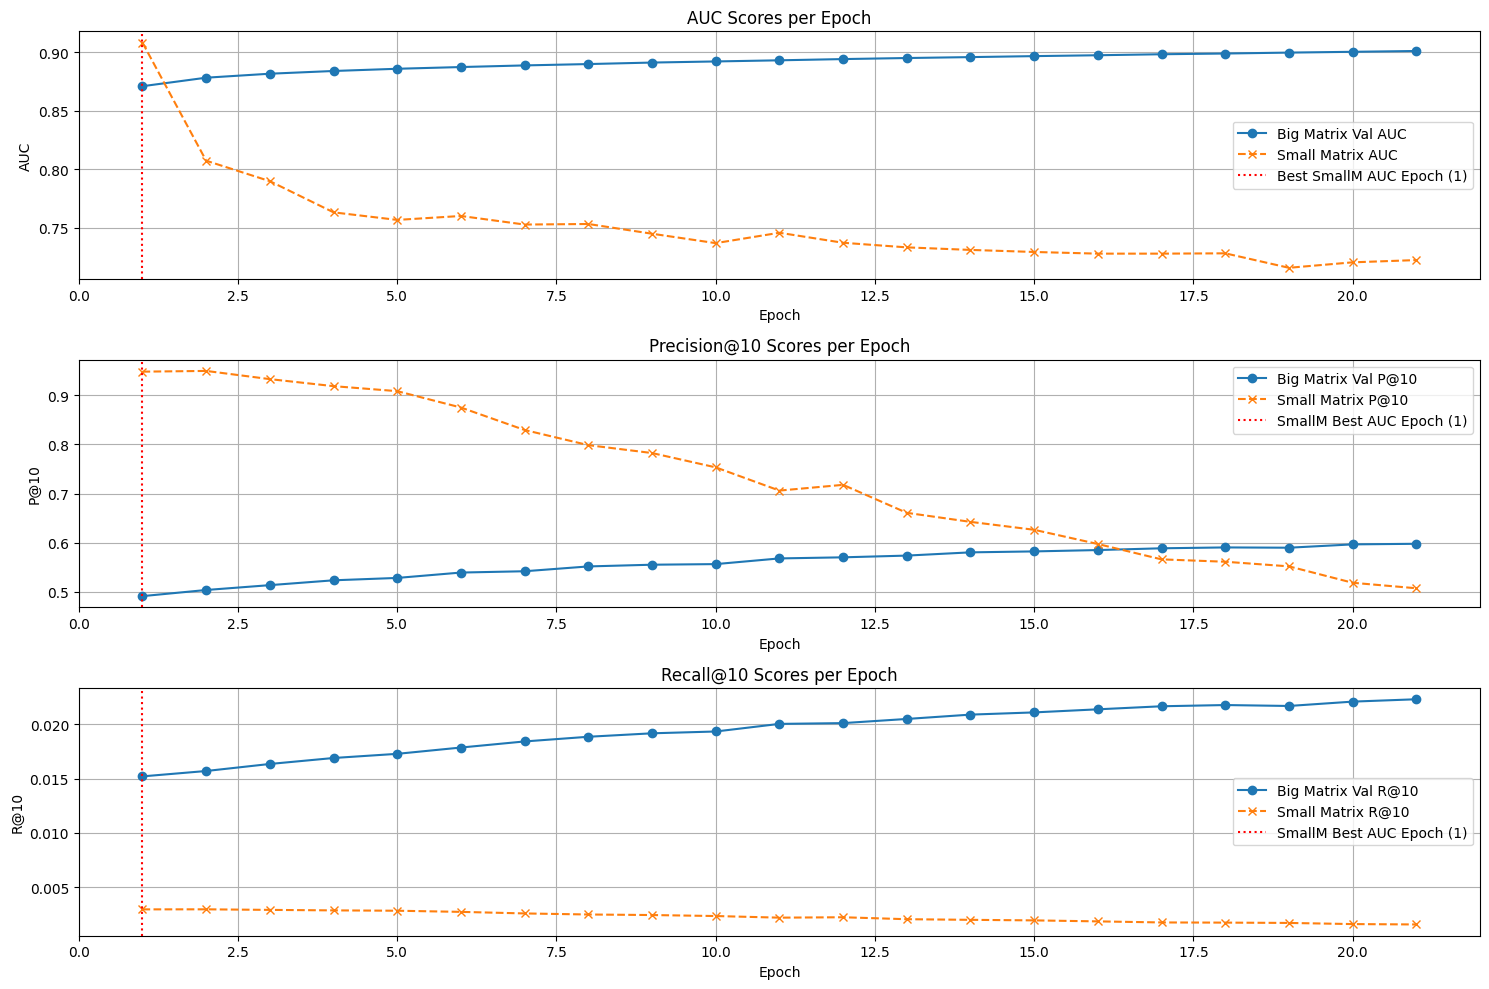

In [35]:
print(f"\nTraining finished.")
if best_epoch_for_small_m != -1:
    print(f"Best AUC for small_matrix was {best_small_m_auc:.4f} at epoch {best_epoch_for_small_m}")
else:
    print("No improvement recorded for small_matrix AUC during training.")

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(epochs_ran, big_val_auc_scores, label='Big Matrix Val AUC', marker='o', linestyle='-')
plt.plot(epochs_ran, small_m_auc_scores, label='Small Matrix AUC', marker='x', linestyle='--')
if best_epoch_for_small_m != -1:
    plt.axvline(x=best_epoch_for_small_m, color='r', linestyle=':', label=f'Best SmallM AUC Epoch ({best_epoch_for_small_m})')
plt.title('AUC Scores per Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(epochs_ran, big_val_p10_scores, label='Big Matrix Val P@10', marker='o', linestyle='-')
plt.plot(epochs_ran, small_m_p10_scores, label='Small Matrix P@10', marker='x', linestyle='--')
if best_epoch_for_small_m != -1 and small_m_p10_scores:
     plt.axvline(x=best_epoch_for_small_m, color='r', linestyle=':', label=f'SmallM Best AUC Epoch ({best_epoch_for_small_m})')
plt.title('Precision@10 Scores per Epoch')
plt.xlabel('Epoch')
plt.ylabel('P@10')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(epochs_ran, big_val_r10_scores, label='Big Matrix Val R@10', marker='o', linestyle='-')
plt.plot(epochs_ran, small_m_r10_scores, label='Small Matrix R@10', marker='x', linestyle='--')
if best_epoch_for_small_m != -1 and small_m_r10_scores:
    plt.axvline(x=best_epoch_for_small_m, color='r', linestyle=':', label=f'SmallM Best AUC Epoch ({best_epoch_for_small_m})')
plt.title('Recall@10 Scores per Epoch')
plt.xlabel('Epoch')
plt.ylabel('R@10')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Model Results and Analysis

#### Initial Model with Full Category Features

The first model iteration included hierarchical category features:
- `first_level_category_name`
- `second_level_category_name`
- `third_level_category_name`

These features enhanced performance on the `big_matrix`, but when evaluated on the `small_matrix`, a significant performance drop was observed.

**Performance Metrics:**

**Training Set (on `big_matrix`):**
- Precision@10: **0.7346**
- Recall@10: **0.0097**
- AUC: **0.9075**

**Validation Set (from `big_matrix`):**
- Precision@10: **0.6657**
- Recall@10: **0.0289**
- AUC: **0.9193**

**Evaluation on `small_matrix`:**
- Precision@10: **0.0313**
- Recall@10: **0.0001**
- AUC: **0.6095**

The sharp drop in Precision@10 from ~0.67 (on the validation set) to ~0.03 (on the `small_matrix`) indicates a **generalization issue**. While the model effectively leveraged category features in the `big_matrix`, those same features did not translate well to users in the `small_matrix`. In fact, their inclusion may have been detrimental.

#### Impact of Feature Adjustments

To address this, I attempted to improve generalization to the `small_matrix` by **removing some category features**. Unfortunately, this led to even poorer performance, indicating that simply excluding features without better alternatives wasn't sufficient.

Further investigation revealed that **only about 50% of users in the `small_matrix` had interacted with videos containing tags**. Given this, I experimented with **removing tags entirely** from the feature set for models tuned specifically to the `small_matrix`. This aimed to test whether inconsistent tagging data was introducing noise.


### Make recommendations

In [61]:
# Function to make recommendations
def recommend_for_user(user_id, model, dataset, user_features_matrix, item_features_matrix, n=10):
    # Get all item IDs
    all_items = dataset.mapping()[2]
    all_item_ids = list(all_items.keys())

    # Create user array
    user_array = np.array([user_id] * len(all_item_ids))
    item_array = np.array(all_item_ids)

    # Predict scores
    scores = model.predict(
        user_array,
        item_array,
        user_features=user_features_matrix,
        item_features=item_features_matrix
    )

    top_items = item_array[np.argsort(-scores)][:n]

    item_id_map = {v: k for k, v in all_items.items()}
    recommended_items = [item_id_map[item] for item in top_items]

    return recommended_items

user_id = small_matrix['user_id'].iloc[0]
recommendations = recommend_for_user(
    user_id,
    model,
    dataset,
    user_features_matrix,
    item_features_matrix
)
print(f"Recommendations for user {user_id}: {recommendations}")

Recommendations for user 14: [np.int64(5279), np.int64(6942), np.int64(1137), np.int64(5492), np.int64(6874), np.int64(7319), np.int64(339), np.int64(9617), np.int64(5440), np.int64(3860)]
